In [1]:
# Import libraries
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# List all xlsx files in the target directory and subdirectories
def list_files(target_dir):
    files = []
    for root, dirs, filenames in os.walk(os.path.join(".", target_dir)):
        for filename in filenames:
            if filename.endswith(".xlsx"):
                files.append(os.path.join(root, filename))
    return files

# Merge all files returned by list_files(target_dir) in a single dataframe
def merge_files(target_dir):
    import pandas as pd
    files = list_files(target_dir)
    df = pd.DataFrame()
    for file in files:
        df = pd.concat([df, pd.read_excel(file, engine="openpyxl")], ignore_index=True)
    return df

# Merge all files and save the result in a single dataframe
df_experiments = merge_files("new_data")

In [3]:
# Show the column names in df_experiments
print(df_experiments.columns)

Index(['execution_id', 'policy_frequency [Hz]', 'policy', 'lane_configuration',
       'run_enforcer [True/False]', 'runtime_model', 'crash [True/False]',
       'traveled_distance_on_right_lane [km]', 'traveled_distance [km]',
       'effective_duration [s simulation time]', 'enforcer_interventions [#]',
       'enforcer_model_start [ms clock wall time]',
       'enforcer_model_stop [ms clock wall time]',
       'total_enforcement_execution_time [ms clock wall time]',
       'max_enforcement_execution_time [ms clock wall time]',
       'test_execution_time [ms clock wall time]'],
      dtype='object')


In [4]:
# For rows having runtime_model as NaN, set runtime_model to 'NONE'
df_experiments["runtime_model"].fillna("NONE", inplace=True)
# For rows having runtime_model as BBB set CCC
df_experiments["runtime_model"] = df_experiments["runtime_model"].replace("SafetyEnforcerKeepRight.asm", "KeepRight")
df_experiments["runtime_model"] = df_experiments["runtime_model"].replace("SafetyEnforcerFaster.asm", "Faster")
df_experiments["runtime_model"] = df_experiments["runtime_model"].replace("SafetyEnforcerSlower.asm", "Slower")
df_experiments["runtime_model"] = df_experiments["runtime_model"].replace("SafetyEnforcerSuperSafe.asm", "SuperSafe")

In [5]:
# Filter only rows with laneconfigurations as '1' and '2'
df_experiments_multi = df_experiments[df_experiments['lane_configuration'].eq("multi")]
df_experiments_single = df_experiments[df_experiments['lane_configuration'].eq("single")]

In [6]:
# Add columns for the relative number of enforer interventions and total enforcement overhead
df_experiments['enforcement_interventions [%]'] = 100 * df_experiments['enforcer_interventions [#]'] / (df_experiments['policy_frequency [Hz]'] * df_experiments['effective_duration [s simulation time]'])
df_experiments['enforcement_overhead [ms clock wall time]'] = df_experiments['enforcer_model_start [ms clock wall time]'] + df_experiments['enforcer_model_stop [ms clock wall time]'] + df_experiments['total_enforcement_execution_time [ms clock wall time]']

# Define the grouping columns
group_cols = ['policy_frequency [Hz]', 'lane_configuration', 'policy', 'runtime_model']

# Define the aggregation functions for each column that must be in the aggregate dataframe
agg_funcs = {
    'crash [True/False]': 'sum',
    'traveled_distance [km]': ['mean', 'std'], 
    'traveled_distance_on_right_lane [km]': ['mean', 'std'], 
    'enforcement_interventions [%]': ['mean', 'std'],
    'test_execution_time [ms clock wall time]': ['mean', 'std'], 
    'enforcement_overhead [ms clock wall time]': ['mean', 'std']
}

# Perform the aggregation
df_aggregated = df_experiments.groupby(group_cols).agg(agg_funcs)

# Flatten the multi-index columns
df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

# Reset index to make it a normal dataframe
df_aggregated = df_aggregated.reset_index()

# Convert all time-related columns from milliseconds to seconds
time_columns = [
    'test_execution_time [ms clock wall time]_mean',
    'test_execution_time [ms clock wall time]_std',
    'enforcement_overhead [ms clock wall time]_mean',
    'enforcement_overhead [ms clock wall time]_std'
]
df_aggregated[time_columns] = df_aggregated[time_columns] / 1000

# Define the custom order for sorting
custom_order = {
    'policy_frequency [Hz]': [1, 2],
    'lane_configuration': ['single', 'multi'],
    'policy': ['base', 'adversarial'],
    'runtime_model': ['NONE', 'SuperSafe', 'Slower', 'Faster', "KeepRight"]
}

# Convert the columns to categorical with the specified order
for col, order in custom_order.items():
    df_aggregated[col] = pd.Categorical(df_aggregated[col], categories=order, ordered=True)

# Sort the dataframe based on the custom order
df_aggregated = df_aggregated.sort_values(by=group_cols)

# Save the resulting dataframe to xlsx
df_aggregated.to_excel("aggregated_results.xlsx", index=False, float_format="%.2f", engine='openpyxl')

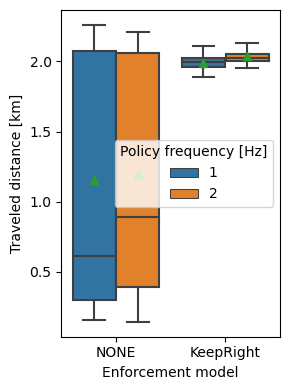

In [7]:
# Figure 8x5
plt.figure(figsize=(3,4))
sns.boxplot(x='runtime_model', y='traveled_distance [km]', data=df_experiments_multi, hue='policy_frequency [Hz]', showfliers=False, showmeans=True, order = ['NONE', 'KeepRight'])
plt.legend(title='Policy frequency [Hz]', loc='best')
# Values on the x-axis should be in the following order NONE, KeepRight
plt.ylabel('Traveled distance [km]')
plt.xticks(rotation=0)
plt.xlabel('Enforcement model')
plt.tight_layout()
# Save the figure 
plt.savefig('figures/traveled_distance_multi.pdf')
plt.show()

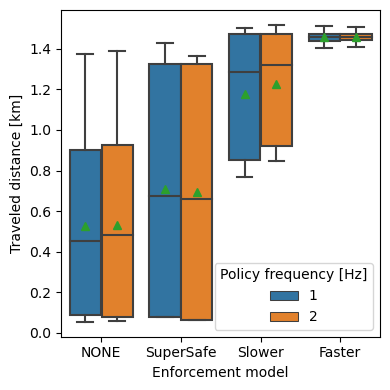

In [8]:
plt.figure(figsize=(4,4))
sns.boxplot(x='runtime_model', y='traveled_distance [km]', data=df_experiments_single, hue='policy_frequency [Hz]', showfliers=False, showmeans=True, order = ['NONE', 'SuperSafe', 'Slower', 'Faster'])
plt.legend(title='Policy frequency [Hz]', loc='best')
plt.ylabel('Traveled distance [km]')
plt.xticks(rotation=0)
plt.xlabel('Enforcement model')
plt.tight_layout()
# Save the figure 
plt.savefig('figures/traveled_distance_single.pdf')
plt.show()

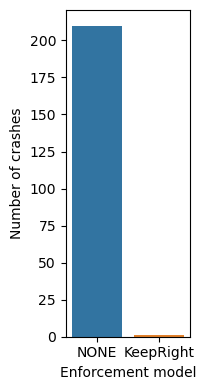

In [9]:
# Filter the DataFrame where 'crash [True/False]' is True
crash_df = df_experiments[df_experiments['crash [True/False]'] == True]

# Count occurrences of crashes for each runtime model
crash_counts = crash_df['runtime_model'].value_counts()

# Report on a histogram the number of crashes per runtime model. We count an execution as a crash if 'crash [True/False]' is True. Transpose the plot
plt.figure(figsize=(2.1,4))
sns.barplot(x=crash_counts.index, y=crash_counts.values)
plt.ylabel('Number of crashes')
plt.xticks(rotation=0)
plt.xlabel('Enforcement model')
plt.tight_layout()
# Save the figure 
plt.savefig('figures/crashes.pdf')
plt.show()